In [3]:
import pandas as pd
import numpy as np

database = pd.read_csv('~/FINAL_DATE_', nrows=3000)

А теперь нейронки(а) аля логистическая регрессия!

In [4]:
from torch import nn
import torch
import torch.nn.functional as F

In [5]:
database = database.drop(['Unnamed: 0'], axis=1)
X = database.drop(['class', 'UNIPROT_SYMBOL_A', 'UNIPROT_SYMBOL_B'], axis=1)
y = database['class']

In [6]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(686, 1))
model.add_module('l2', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [7]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 686]), torch.Size([1])]


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [9]:
history = []

loss_function = nn.MSELoss()

for i in range(100000):
    model.train()
    opt.zero_grad()  
    
    ix = np.random.randint(0, len(X_train), 300)
    x_batch = torch.tensor(X_train.iloc[ix].values, dtype=torch.float)
    y_batch = torch.tensor(y_train.iloc[ix].values, dtype=torch.float)
    y_predicted = model(x_batch)
    
    loss = loss_function(y_predicted, y_batch.unsqueeze(1))
    loss.backward()     
    opt.step()             

    history.append(loss.data.numpy())
    if i % 10000 == 0:
        print("step #%i | loss = %.3f" % (i, loss))

step #0 | loss = 0.313
step #10000 | loss = 0.118
step #20000 | loss = 0.097
step #30000 | loss = 0.087
step #40000 | loss = 0.075
step #50000 | loss = 0.091
step #60000 | loss = 0.077
step #70000 | loss = 0.062
step #80000 | loss = 0.058
step #90000 | loss = 0.052


In [10]:
predicted_y_test = model(torch.tensor(X_test.values).float())[:, 0].data.numpy() > 0.5

In [11]:
np.mean(predicted_y_test == y_test)

0.8533333333333334

Заметим, что точность достигает точности, полученной с помощью обычной логистической регрессии.

(-2.0, 2.0)

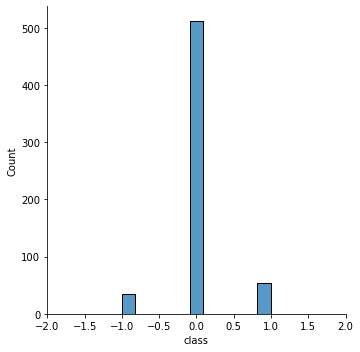

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(predicted_y_test - y_test)
plt.xlim(-2, 2)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(-5.0, 5.0)

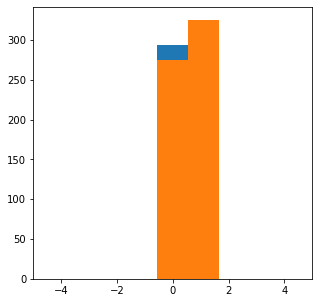

In [16]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 10))
plt.hist(predicted_y_test, bins=np.linspace(-5, 5, 10))
plt.xlim(-5, 5)

Используем наивный байесовский классификатор(naive Bayes).

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [25]:
gnb.score(X_test, y_test)

0.6466666666666666

In [26]:
print(classification_report(y_test, y_pred, target_names=['Non-churned', 'Churned']))

              precision    recall  f1-score   support

 Non-churned       0.63      0.90      0.74       333
     Churned       0.73      0.33      0.45       267

    accuracy                           0.65       600
   macro avg       0.68      0.61      0.60       600
weighted avg       0.67      0.65      0.61       600



(-2.0, 2.0)

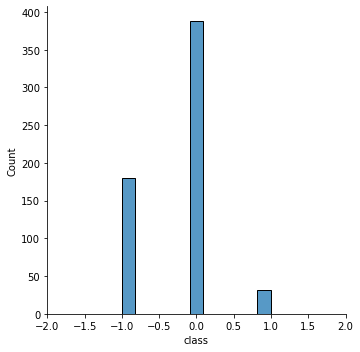

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(y_pred - y_test)
plt.xlim(-2, 2)

(-5.0, 5.0)

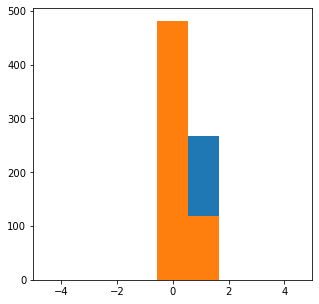

In [28]:
plt.figure(figsize=(5, 5))
plt.hist(y_test, bins=np.linspace(-5, 5, 10))
plt.hist(y_pred, bins=np.linspace(-5, 5, 10))
plt.xlim(-5, 5)

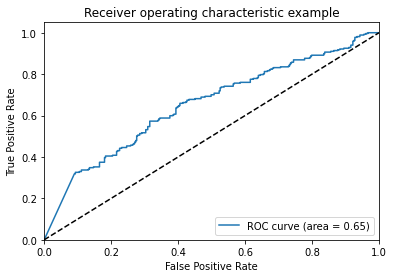

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
def roc_a(y_test, y_predicted_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
    roc_auc= auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
y_pred_prob = gnb.predict_proba(X_test)
roc_a(y_test, y_pred_prob)

Точность получена низкая, но достаточно хорошая для такого способа. Это свидетельствует о хорошей разрешимости задачи. Необходимо еще исследовать ее разрешимость с помощью сверточных нейронных сетей, а также используя другие способы кодирования последовательностей аминокислот.